In [22]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

import numpy as np
import math
import pandas as pd
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 30)
pd.options.display.float_format = '{:,}'.format


In [90]:
# FUNCTIONS

def enum_category(label):
    num=0
    if label == 'Poor' : num =1
    elif label == 'Fair': num = 2
    elif label == 'Average': num = 3
    elif label == 'Good': num = 4
    elif label == 'Very Good': num = 5
    else: return label
    
    return int(num)

def log_and_normalize (data, log, norm_type):
    if log == 'log':
        data = np.log(data) 
    if norm_type == 1:
        data = (data-np.mean(data))/np.std(data)  # std normalisation
    elif norm_type == 2:
        data = (data-min(data))/(max(data)-min(data))      #  min_max_min
    elif norm_type == 3:
        data = (data-np.mean(data))/(max(data)-min(data))  # mean norm
    
    return data    

def hot_encode (data, directions):
    if directions == 'yes':
        data = pd.get_dummies(data, prefix=data.name[:3], drop_first=True)
    return data

In [91]:
df=pd.read_csv('data/kc_house_data.csv', index_col=0)

# initial cleaning operations (splitting , etc)

df["grade"]=df["grade"].map(lambda x: x.split()[0]).astype(int)
df['condition'] = df['condition'].apply(enum_category)


In [92]:
# Prepairing data

df['yr_renovated'].fillna(value=df['yr_built'],inplace=True)
df['yr_renovated'] = np.where(df['yr_renovated'] == 0, df['yr_built'], df['yr_renovated'])

df['waterfront'].fillna(value='NO',inplace=True)

#NEW FEATURES

df['lat_range']=pd.cut(df['lat'], 30)
df['long_range']=pd.cut(df['long'], 30)
df['coord_range']=np.array(zip(df['lat_range'],df['long_range']))
df['decade']=pd.cut(df['yr_built'], 12)

#FILTER
#df=df[df['yr_built']>1980]

In [93]:
data_fin=pd.DataFrame([])

price=df[["price"]]

cont=["sqft_living", 'sqft_lot', 'sqft_living15']

#cont=["sqft_living"]
cat=[ 'grade', 'zipcode', 'view', 'waterfront','decade']


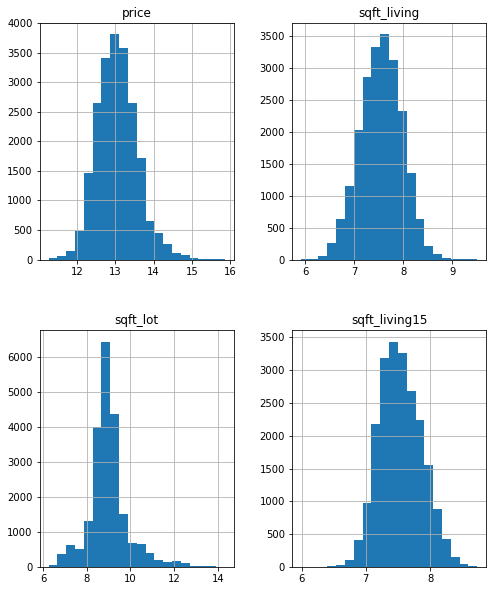

In [94]:
# Log transform and normalize
price=log_and_normalize(price, 'log', 0)
for col in cont:
    data_fin[col]=log_and_normalize(df[col], 'log', 0)


pd.concat([price, data_fin], axis=1).hist(figsize=(8,10), bins=20);


In [96]:
# One hot encode categoricals
for col in cat:
    new_cols=hot_encode(df[col], 'yes')
    data_fin = pd.concat([data_fin, new_cols], axis=1)

data_fin = pd.concat([price, data_fin], axis=1)

In [61]:
# Create OLS linear model
pred=data_fin.drop(columns=["price"]).copy()

pred_int = sm.add_constant(pred)
model = sm.OLS(price,pred_int).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     1625.
Date:                Sat, 26 Mar 2022   Prob (F-statistic):               0.00
Time:                        21:37:23   Log-Likelihood:                 6197.2
No. Observations:               21597   AIC:                        -1.220e+04
Df Residuals:                   21498   BIC:                        -1.141e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        8.3519      0.189     44.228      0.000       7.982       8.722
sqft_living                  0.4067      0.005     78.147      0.000       0.397       0.417
sqft_lot                     0.0701      0.002     32.716      0.000       0.066       0.074
sqft_living15                0.1323      0.007     19.702      0.000       0.119       0.146
gra_4                       -0.6009      0.186     -3.233      0.001      -0.965      -0.237
gra_5                       -0.5968      0.183     -3.263      0.001      -0.955      -0.238
gra_6                       -0.4921      0.183     -2.695      0.007      -0.850      -0.134
gra_7                       -0.3967      0.183     -2.172      0.030      -0.755      -0.039
gra_8                       -0.3039      0.183     -1.664      0.096      -0.662       0.054
gra_9                       -0.1873      0.183     -1.025      0.305      -0.546       0.171
gra_10                      -0.0890      0.183     -0.487      0.626      -0.447       0.269
gra_11                       0.0358      0.183      0.195      0.845      -0.323       0.395
gra_12                       0.1647      0.184      0.895      0.371      -0.196       0.525
gra_13                       0.4718      0.190      2.484      0.013       0.099       0.844
zip_98002                    0.0203      0.016      1.256      0.209      -0.011       0.052
zip_98003                    0.0365      0.015      2.510      0.012       0.008       0.065
zip_98004                    1.1366      0.014     79.194      0.000       1.109       1.165
zip_98005                    0.7580      0.017     43.911      0.000       0.724       0.792
zip_98006                    0.6662      0.013     51.663      0.000       0.641       0.691
zip_98007                    0.6846      0.018     37.549      0.000       0.649       0.720
zip_98008                    0.6874      0.015     46.850      0.000       0.659       0.716
zip_98010                    0.2409      0.021     11.647      0.000       0.200       0.281
zip_98011                    0.4534      0.016     27.896      0.000       0.422       0.485
zip_98014                    0.2825      0.019     14.740      0.000       0.245       0.320
zip_98019                    0.3071      0.016     18.731      0.000       0.275       0.339
zip_98022                    0.0548      0.015      3.545      0.000       0.025       0.085
zip_98023                   -0.0057      0.013     -0.453      0.651      -0.031       0.019
zip_98024                    0.4015      0.023     17.686      0.000       0.357       0.446
zip_98027                    0.5134      0.013     38.852      0.000       0.487       0.539
zip_98028                    0.4158      0.015     28.672      0.000       0.387       0.444
zip_98029     